# W207 Spring 2019 Final Project
## Kaggle Competition: Forest Cover Prediction
**Pierce Coggins, Jake Mitchell, Debasish Mukhopadhyay, and Tim Slade**

# Table of Contents/Section Notes

- [Introduction](#introduction)
  - In which we discuss the problem and why it matters
  - [Housekeeping](#housekeeping)
    - In which we deal with basic prep and setup issues
- [About the Data](#aboutTheData)
  - EDA, charts, data cleaning
- [Feature Engineering](#featureEngineering)
  - Describe a basic model that we will use to test the usefulness of new features (LR or NB)
  - Normalization
  - Each added or removed feature
- [Models](#models)
  - Maybe choose 4 to test out?  Don't want this section to get too lengthy, and each model should be covered in some detail
- [Results](#results)
  - What went well, what went poorly
  - Final comparison of models on test data
- [Conclusion](#conclusion)
- [Annexes](#annexA)
  

<a id="introduction"></a>
# Introduction

In this report, we will attempt to predict the forest cover type (defined as the predominant type of tree cover) for a given area of land in Colorado given only cartographic variables as inputs.  This problem and dataset were initially posted as a Kaggle competition in 2015.  We have chosen to tackle this problem as it allows for many different machine learning techniques to be attempted and explored.  The report will go through the process of building a capable model from data cleaning through final testing.

The problem of understanding what type of vegetation is present in a difficult to access area is a surprisingly important one.  In this particular example the forests of Colorado are very diverse, and each type of tree cover has its own benefits and dangers.  For example many of the pine trees in Colorado are succeptable to the [mountain pine beetle](https://csfs.colostate.edu/forest-management/common-forest-insects-diseases/mountain-pine-beetle/), while the Spruce and Fir trees are relatively safe from the beetles.  Without directly going to every location in the mountains of Colorado, it is very difficult to distinguish these types of trees as they look very similar from the air.  It is relatively easy to get cartographic data for a large swath of the mountains however, and if it is possible to accurately predict the tree type from the cartographic information alone then all of the Colorado forest could be mapped by likely forest cover type. That information would be invaluable to firefighters and forest service personnel to direct their efforts where it will have the most impact.

If you would like to learn more about the problem or try for yourself, all information and data can be found from the kaggle competition:<br>[Kaggle's Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction).

<a id="housekeeping"></a>
## Housekeeping

### Importing Libraries and Helper Functions

In [72]:
%matplotlib inline

# General libraries
import pandas as pd
import numpy as np
import os
import copy
import warnings
import statsmodels.api as sm
from scipy import stats

# Plotting and printing libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import pprint

# Model-building libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, scale

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# Run the helper functions notebook
%run w207_final_helper_functions.ipynb

### Loading the data

In [2]:
%%capture --no-stdout --no-display
full_data = pd.DataFrame.from_csv('./train.csv')
full_data.shape

(15120, 55)

The forest cover types we aim to predict are bundled with the features used to predict them. Our first step is therefore to separate them out, lest we accidentally let our models peek at the outcomes. We also want to split the dataset into _train_ and _test_ subsets; this will give us insight into how well our chosen models and parameters will perform against out-of-sample data.

The original dataset contained 15,120 observations. We will train our models on 90% of the data and hold out 10% for testing. We thus expect to have approximately 0.9 * 15,120 = 13,608 observations in our training dataset.

### Removing labels and splitting the data

In [3]:
# Separating out the labels
full_labels = full_data['Cover_Type']
full_features = full_data.drop('Cover_Type', axis=1)
label_names = {'1':'Spruce/Fir', 
               '2':'Lodgepole Pine', 
               '3':'Ponderosa Pine', 
               '4':'Cottonwood/Willow', 
               '5':'Aspen',
               '6':'Douglas Fir',
               '7':'Krummholz'}

# Setting seed so we get consistent results from our splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(full_features, full_labels, test_size=0.10)

# Verifying our data shapes are as expected
print(f'''
{'':^16} | {'Observations':^12} | {'Features':^10} |
{'-'*46}
{'Training dataset':^16} | {X_train.shape[0]:^12} | {X_train.shape[1]:^10} |
{'Training labels':^16} | {y_train.shape[0]:^12} | {'--':^10} |
{'Test dataset':^16} | {X_test.shape[0]:^12} | {X_test.shape[1]:^10} |
{'Test labels':^16} | {y_test.shape[0]:^12} | {'--':^10} |
''')


                 | Observations |  Features  |
----------------------------------------------
Training dataset |    13608     |     54     |
Training labels  |    13608     |     --     |
  Test dataset   |     1512     |     54     |
  Test labels    |     1512     |     --     |



<a id="aboutTheData"></a>

# About the Data

The data comes from several wilderness areas in northern Colorado, specifically the Rawah Wilderness Area, Neota Wilderness Area, Comanche Peak Wilderness Area, and the Cache la Poudre Wilderness Area.  These are all fairly remote areas of Colorado which is why they were chosen, as there is less human influence in these places.

The features in the dataset are all cartographic measures of a 30x30m square plot of land.  We have 10 simple features. The 11th and 12th - `wilderness_area` and `soil_type` - are categorical variables which are represented as 4 and 40 binary columns respectively in our dataset. We therefore have a total of 10 + 4 + 40 = 54 features to work with.
The list below contains a short description of each feature, including where relevant its range, median, and mean. (See [Annex A](#annexA) for the associated code and further discussion of the exploratory data analysis).

- `Elevation`: _Elevation in meters_
  - **Range**: 1863 to 3849 | **Mean**: 2749.3 | **Median**: 2752


- `Aspect`: _Aspect in degrees azimuth. i.e., degrees clockwise from a line pointed at true North. So North = 0$^\circ$, East = 90$^\circ$, South = 180$^\circ$, and West = 270$^\circ$_
  - **Range**: 0 to 360 | **Mean**: 156.7 | **Median**: 126.0


- `Slope`: _Slope in degrees. 0$^\circ$ would indicate a flat plane; greater values represent steeper slopes._
  - **Range**: 0 to 52 | **Mean**: 16.5 | **Median**: 15.0 


- `Horizontal_Distance_To_Hydrology`: _Horizontal distance to nearest surface water features. Units unspecified._
  - **Range**: 0 to 1343 | **Mean**: 227.2 | **Median**: 180 


- `Vertical_Distance_To_Hydrology`: _Vertical distance to nearest surface water features. Units unspecified._
  - **Range**: -146 to 554 | **Mean**: 51.1 | **Median**: 32.0


- `Horizontal_Distance_To_Roadways`: _Horizontal distance to nearest roadway. Units unspecified._
  - **Range**: 0 to 6890 | **Mean**: 1714.0 | **Median**: 1316


- `Hillshade_9am`: _(0 to 255 index) - Hillshade index at 9am, summer solstice_
  - **Range**: 0 to 254 | **Mean**: 212.7 | **Median**: 220


- `Hillshade_Noon`: _(0 to 255 index) - Hillshade index at noon, summer solstice_
  - **Range**: 99 to 254 | **Mean**: 219.0 | **Median**: 223


- `Hillshade_3pm`: _(0 to 255 index) - Hillshade index at 3pm, summer solstice_
  - **Range**: 0 to 248 | **Mean**: 135.1 | **Median**: 138.0


- `Horizontal_Distance_To_Fire_Points`: _Horizontal distance to nearest wildfire ignition points. Units unspecified._
  - **Range**: 0 to 6993 | **Mean**: 1511.2 | **Median**: 1256 


- `Wilderness_Area`: _(4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation_
  - % of cases - **Area 1**: 24% || **Area 2**: 3% || **Area 3**: 42% || **Area 4**: 31% 


- `Soil_Type`: _(40 binary columns, 0 = absence or 1 = presence) - Soil type designation_
  - The soil types descriptions can be found at the [Kaggle Competition Data Page](https://www.kaggle.com/c/forest-cover-type-prediction/data)

<span style='color:red'>*TODO: Expand cover type explanation, add pictures of tree types.*</span>

### Initial Exploration of the Challenge
The label indicating our data's categorization is contained in the`Cover_Type` variable, and is split up into 7 different designations. While the tree species discussed in the Colorado State Forest Service's [_Colorado's Major Tree Species_](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/) article do not map perfectly to these categories, the article provides some insights that may prove useful in our categorization exercise.

#### Category 1: 'Spruce/Fir'
- Species that might fit into this category include the **Blue Spruce** (which thrives at an altitude of 6700-11500 ft in sandy soils near moisture), the **Engelmann Spruce** (8000-11000 ft, moist north-facing slopes), the **Subalpine Fir** (8000-12000 ft, cold high-elevation forests), and the **White Fir** (7900-10200 ft, moist soils in valleys).

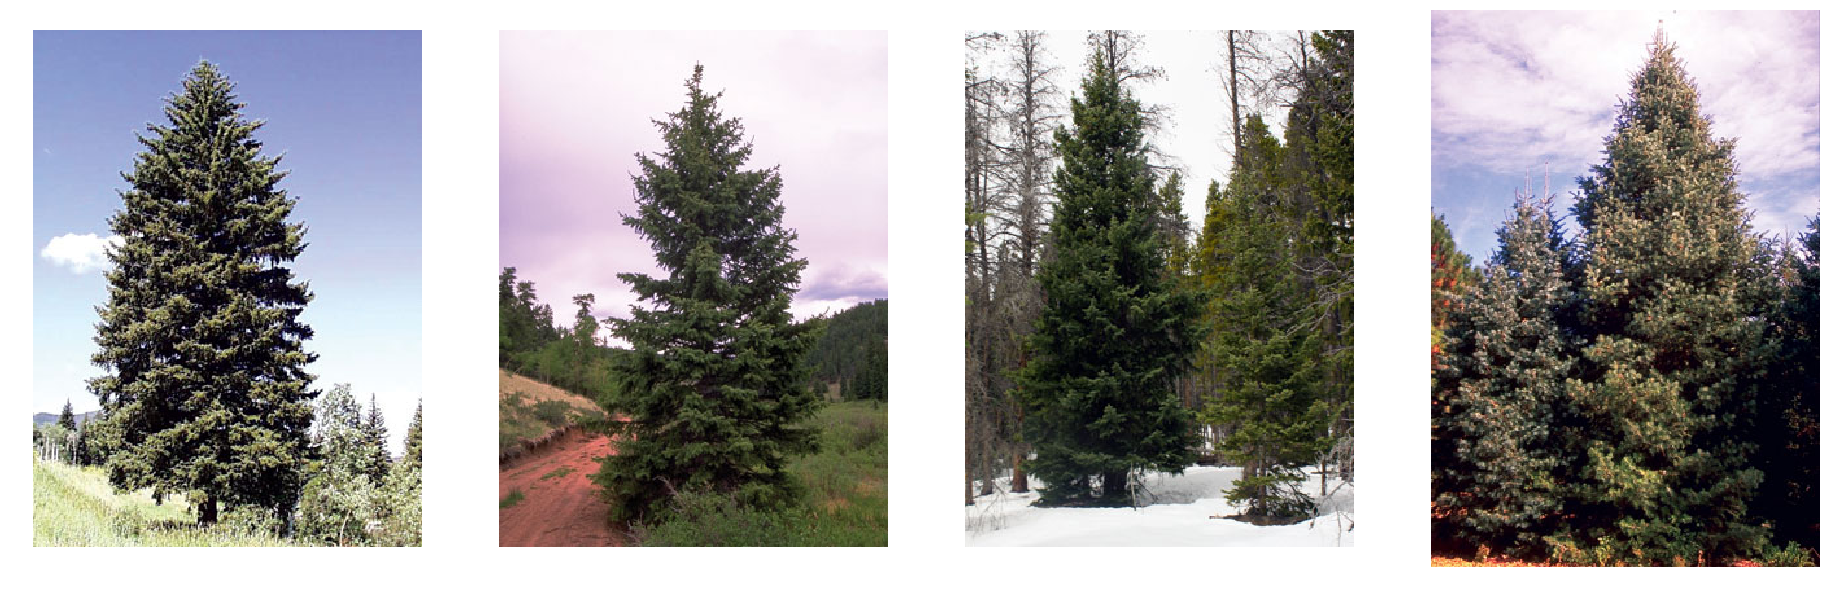

In [4]:
show_photos(['imgs/1_blue-spruce-tree.jpg','imgs/1_engelmann-spruce.jpg','imgs/1_subalpine-fir.jpg','imgs/1_white-fir-tree.jpg'], 4)

#### Category 2: 'Lodgepole Pine'
- The **Lodgepole Pine** thrives in well-drained soils at high elevations (6000-11000 ft).

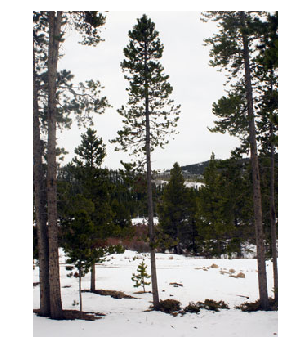

In [5]:
show_photos(['imgs/2_lodgepole-pine.jpg'], 1.5)

#### Category 3: 'Ponderosa Pine'
- The **Ponderosa Pine** thrives in dry, nutrient-poor soils at elevations of 6300-9500 ft. It is often found with Douglas Firs.

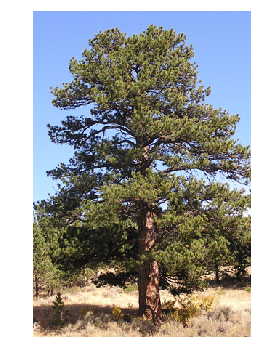

In [6]:
show_photos(['imgs/3_ponderosa-pine.jpg'], 1.5)

#### Category 4: 'Cottonwood/Willow'
- Species that might fit into this category include the **Plains Cottonwood** (which thrives at altitudes of 3500-6500 ft near sources of water), the **Narrowleaf Cottonwood** (5000-8000 ft, moist soils along streams), and the **Peachleaf Willow** (3500-7500 ft, near water sources).

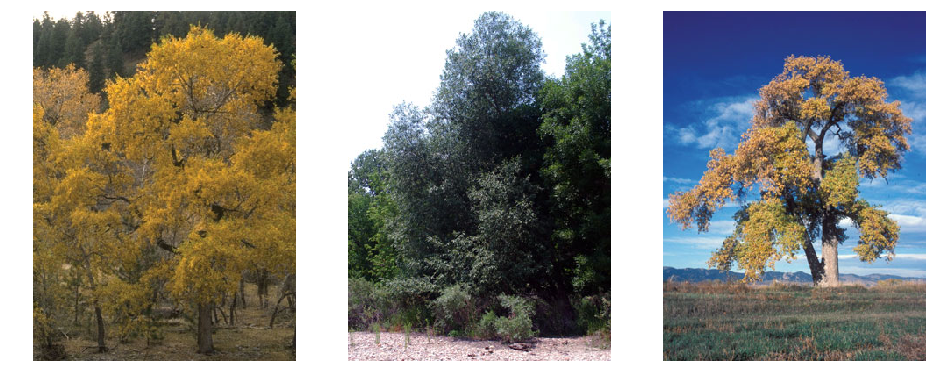

In [7]:
show_photos(['imgs/4_narrowleaf-cottonwood.jpg', 'imgs/4_peachleaf-willow.jpg', 'imgs/4_plains-cottonwood.jpg'], 2)

#### Category 5: 'Aspen'
- The **Quaking Aspen** thrives at altitudes of 6500-11500 ft. While it can be in many soil types, it is especially found on sandy and gravelly slopes.

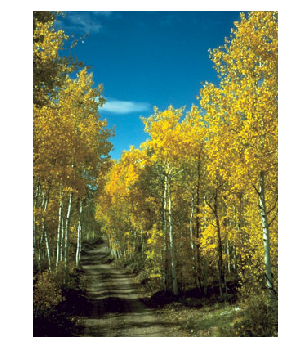

In [8]:
show_photos(['imgs/5_aspen.jpg'], 1.5)

#### Category 6: 'Douglas Fir'
- The **Douglas Fir** thrives at altitudes of 6000-9500 ft in rocky soils of moist northern slopes.

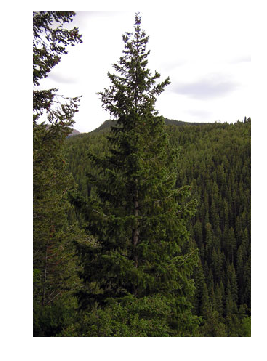

In [9]:
show_photos(['imgs/6_douglas-fir.jpg'], 1.5)

#### Category 7: 'Krummholz'
- Interestingly, _krummholz_ is not a species of tree; it is a type of tree formation (which can emerge among various tree species) that results from consistent long-term exposure to strong, cold winds. Per [Wikipedia](https://en.wikipedia.org/wiki/Krummholz), Subalpine Fir and Engelmann Spruce are often associated with Krummholz conditions (as is Lodgepole Pine, although that is more common in British Columbia). (Photo credit to John Spooner - flickr.com, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=5007578)
 

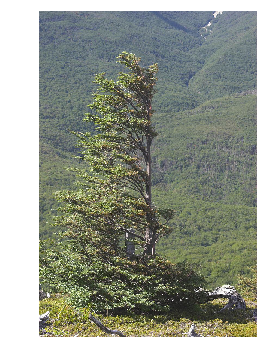

In [10]:
show_photos(['imgs/7_krummholz-banner-tree.jpg'], 1.5)

The brief descriptions we've seen already suggest some avenues of exploration: altitude ranges and access to water seem to be of primary importance.

#### What can we learn from altitude alone?

![title](imgs/altitudeRanges4.png)

The graph above is based upon idealized data from outside sources - our actual dataset might tell a different story. The graph below presents the observed _elevation_ ranges by *cover_type* in our data.

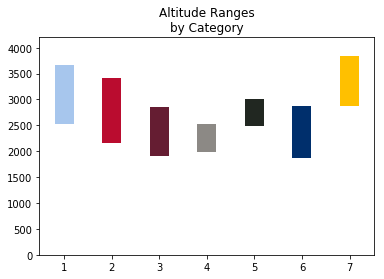

In [78]:
low_end, high_end, middle = get_elevation_ranges(full_data, 'Cover_Type', 'Elevation')

base = np.asarray(low_end - 0)
middle = np.asarray(high_end - low_end)
ceiling = np.asarray(4000 - high_end)

color_dict = {1: '#A7C6ED', 2: '#BA0C2F', 3: '#651D32', 4: '#8C8985',
              5: '#212721', 6: '#002F6C', 7: '#FFC000'}
ind = range(1, 8)
width = 0.4
coloration = [color_dict[x] for x in ind]

# plt.plot(figsize=(8,8))
p1 = plt.bar(ind, base, width, color='w')
p2 = plt.bar(ind, middle, width, bottom=base, color=coloration)
p3 = plt.bar(ind, ceiling, width, bottom=(base+middle), color='w')
plt.title('Altitude Ranges\nby Category')
plt.show()

It's a good thing we verified with our own data, because while one of our intuitions seems fairly accurate, the other seems to be completely inaccurate. Higher elevations do indeed appear to be suggestive of *cover_type* being 1, 2, or 7. However, none of our data reflected elevations below 1863m, and *cover_type*s 3 and 6 appear to be at least as frequently represented in that lower range as *cover_type* 4.

#### What if we bring water into the picture?
The other feature that the article suggests might be highly salient is moisture. How does the picture evolve if we add a measure of the distance to water to the mix?

The graph below is a scatterplot of the Euclidean distance (derived from the `Horizontal_Distance_To_Hydrology` and `Vertical_Distance_To_Hydrology` features) and the `Elevation`, with data points colored by the `Cover_Type`.

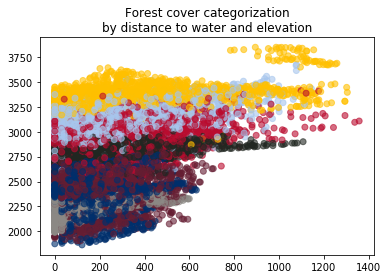

In [82]:
full_features['Euclidean_distance_to_water'] = np.sqrt(full_features['Horizontal_Distance_To_Hydrology']**2 + full_features['Vertical_Distance_To_Hydrology']**2)
dist_to_water = full_features['Euclidean_distance_to_water']
altitude = full_features['Elevation']
color_dict = {1: '#A7C6ED', 2: '#BA0C2F', 3: '#651D32', 4: '#8C8985',
              5: '#212721', 6: '#002F6C', 7: '#FFC000'}
coloration = [color_dict[x] for x in full_labels]
plt.scatter(dist_to_water, altitude, color=coloration, alpha=0.6)
plt.title('Forest cover categorization\nby distance to water and elevation')
plt.show()

The distance to water appears to be informative: `Cover_Type`s 3, 4, and 6 are essentially not found when the distance to water exceeds 750.

### Cleaning the Data
While exploring the data (see [Annex A](#annexA)), we noted that the `Soil_Type7` and `Soil_Type15` variables are never true. Because there is no variation in this feature, it contributes nothing to any modeling. we therefore elect to drop those features before we engage in any modeling.

In [11]:
# Removing uninformative features
full_features = full_features.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

<a id="featureEngineering"></a>

# Feature Engineering

*Copied From Debasish Work*

*@Debasish can you change this code to produce less output or change it to a visualization?  It is a little difficult to understand what this is meant to be showing us. Also maybe move the comments into markdown cells describing what is being done?*

In [12]:
X = full_data.loc[:,'Elevation':'Soil_Type40']
y = full_data.loc[:,"Cover_Type"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
#predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cover_Type   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     204.4
Date:                Sat, 06 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:47:23   Log-Likelihood:                -28021.
No. Observations:               15120   AIC:                         5.614e+04
Df Residuals:                   15069   BIC:                         5.653e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Elevation                             -0.0005      0.000     -4.647      0.000      -0.001      -0.000
Aspect                                 0.0007      0.000      4.674      0.000       0.000       0.001
Slope                                  0.0086      0.005      1.895      0.058      -0.000       0.018
Horizontal_Distance_To_Hydrology      -0.0010   9.39e-05    -11.103      0.000      -0.001      -0.001
Vertical_Distance_To_Hydrology         0.0017      0.000      5.501      0.000       0.001       0.002
Horizontal_Distance_To_Roadways       -0.0002   1.37e-05    -11.409      0.000      -0.000      -0.000
Hillshade_9am                          0.0199      0.005      4.403      0.000       0.011       0.029
Hillshade_Noon                        -0.0155      0.004     -4.139      0.000      -0.023      -0.008
Hillshade_3pm                          0.0129      0.004      3.474      0.001       0.006       0.020
Horizontal_Distance_To_Fire_Points     0.0001   1.51e-05      6.956      0.000    7.53e-05       0.000
Wilderness_Area1                       1.6735      0.728      2.299      0.022       0.247       3.100
Wilderness_Area2                       1.9421      0.738      2.631      0.009       0.495       3.389
Wilderness_Area3                       2.8779      0.730      3.942      0.000       1.447       4.309
Wilderness_Area4                       2.4194      0.720      3.360      0.001       1.008       3.831
Soil_Type1                             0.0754      0.133      0.568      0.570      -0.185       0.336
Soil_Type2                             0.1233      0.116      1.062      0.288      -0.104       0.351
Soil_Type3                            -0.3005      0.119     -2.526      0.012      -0.534      -0.067
Soil_Type4                            -0.4328      0.115     -3.774      0.000      -0.658      -0.208
Soil_Type5                             0.4476      0.157      2.860      0.004       0.141       0.754
Soil_Type6                             0.0998      0.121      0.824      0.410      -0.138       0.337
Soil_Type7                          2.952e-12   1.16e-11      0.255      0.799   -1.97e-11    2.57e-11
Soil_Type8                            -0.5434      1.513     -0.359      0.719      -3.508       2.422
Soil_Type9                            -1.1802      0.488     -2.416      0.016      -2.138      -0.223
Soil_Type10                            0.6042      0.105      5.761      0.000       0.399       0.810
Soil_Type11                           -0.0121      0.122     -0.099      0.921      -0.251       0.227
Soil_Type12                           -0.9824      0.144     -6.824      0.000      -1.265      -0.700
Soil_Type13                            0.3885      0.124      3.143      0.002       0.146      

*@Debasish can you add some commentary on why you chose to add these features and such?*

In [13]:
# Add a few features
engineered_data = full_data.copy()

#print(engineered_data['Horizontal_Distance_To_Hydrology']/(np.mean(engineered_data['Horizontal_Distance_To_Hydrology']) ))
#print(engineered_data['Horizontal_Distance_To_Roadways']/(np.mean(engineered_data['Horizontal_Distance_To_Roadways']) ))
#engineered_data.iloc[:,[4,6,36,49,51,52,53,54]]
engineered_data['Norm Horizontal_Distance_To_Hydrology'] = engineered_data['Horizontal_Distance_To_Hydrology']/(np.mean(full_data['Horizontal_Distance_To_Hydrology']) )
engineered_data['Norm Horizontal_Distance_To_Roadways'] = engineered_data['Horizontal_Distance_To_Roadways']/(np.mean(full_data['Horizontal_Distance_To_Roadways']) )

engineered_data['Soil1_21'] = engineered_data.loc[:,'Soil_Type1':'Soil_Type21'].sum(axis=1)
engineered_data['Soil23_34'] = engineered_data.loc[:,'Soil_Type23':'Soil_Type34'].sum(axis=1) 
#Merge 2_1 and 23_34 in one single feature
engineered_data['Soil_other'] = np.add(engineered_data['Soil1_21'],engineered_data['Soil23_34'])

#print(engineered_data.loc[:,'Soil_Type35':'Soil_Type40'] , engineered_data.loc[:,'Soil_Type1':'Soil_Type21'].sum(axis=1),engineered_data.loc[:,'Soil_Type23':'Soil_Type34'].sum(axis=1) )

#np.add(engineered_data.iloc[:,[53]],  engineered_data.iloc[:,[54]])

# Separating out the labels
engineered_labels = engineered_data['Cover_Type']
engineered_features = engineered_data.drop('Cover_Type', axis=1)
featured_features = engineered_data[["Soil_Type39", "Soil_Type40", "Norm Horizontal_Distance_To_Hydrology", "Norm Horizontal_Distance_To_Roadways", "Soil1_21", "Soil23_34","Soil_other"]]
#df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)

# Setting seed so we get consistent results from our splitting
np.random.seed(0)

FX_train, FX_test, Fy_train, Fy_test = train_test_split(featured_features, engineered_labels, test_size=0.10)

# Verifying our data shapes are as expected
print(f'''
Training dataset shape: {X_train.shape}
Training label shape: {y_train.shape}
Dev dataset shape: {X_test.shape}
Dev label shape: {y_test.shape}

#Deb
Featured Training dataset shape: {FX_train.shape}
Featured Dev dataset shape: {FX_test.shape}
#Deb
''')


Training dataset shape: (13608, 54)
Training label shape: (13608,)
Dev dataset shape: (1512, 54)
Dev label shape: (1512,)

#Deb
Featured Training dataset shape: (13608, 7)
Featured Dev dataset shape: (1512, 7)
#Deb



In [14]:
FX_train.head()

,Soil_Type39,Soil_Type40,Norm Horizontal_Distance_To_Hydrology,Norm Horizontal_Distance_To_Roadways,Soil1_21,Soil23_34,Soil_other
Id,,,,,,,
7810,0,0,0.294900,0.374557,0,1,1
5194,0,0,0.801071,0.408396,1,0,1
10664,0,0,0.396134,1.462057,1,0,1
6087,0,0,0.374127,0.805123,1,0,1
3065,0,0,2.196344,0.315632,1,0,1


In [15]:
# Let's run regression to see how the new columns are doing
X = FX_train
y = Fy_train
# Note the difference in argument order
model = sm.OLS(y, X).fit()
#predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cover_Type   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     7235.
Date:                Sat, 06 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:47:23   Log-Likelihood:                -29956.
No. Observations:               13608   AIC:                         5.992e+04
Df Residuals:                   13602   BIC:                         5.997e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Soil_Type39                               4.9060      0.097     50.493      0.000       4.716       5.096
Soil_Type40                               4.5269      0.121     37.540      0.000       4.291       4.763
Norm Horizontal_Distance_To_Hydrology     0.3399      0.020     16.608      0.000       0.300       0.380
Norm Horizontal_Distance_To_Roadways      0.6188      0.024     25.977      0.000       0.572       0.666
Soil1_21                                  1.7195      0.021     83.277      0.000       1.679       1.760
Soil23_34                                 0.0390      0.028      1.369      0.171      -0.017       0.095
Soil_other                                1.7585      0.022     79.381      0.000       1.715       1.802
==============================================================================
Omnibus:                      466.670   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              519.058
Skew:                           0.456   Prob(JB):                    1.94e-113
Kurtosis:                       3.292   Cond. No.                     1.22e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### How to Test Feature Changes

Without _a priori_ knowledge of how the interplay between soil types, topography, hydrology, etc. affects forest cover, we need a way to view the performance of new features.  As such we will use a simple Gaussian Naive Bayes model to do predictions, and quanitify the results using cross-validation.  We will be tracking performance across precision, recall, and f1-score.

#### Naïve Bayes

One reasonable place to begin might be a Naïve Bayes classifier. While it is unlikely that all of the features at our disposal are _strictly_ independent, we may be able to relax the assumption of independence enough to explore how a NB model performs.

We don't want a Bernoulli NB model: our features are not uniformly binary-valued. We also don't want a Multinomial NB model: per the documentation, it assumes integer feature counts. A Gaussian NB, on the other hand, might work well. While it assumes that the likelihoods of the features are Gaussian - and this is not necessarily strictly the case - it may be worth trying.

In [16]:
# Testing on the unscaled data
cross_validate_model(GaussianNB(), X_train, y_train, name='GaussianNB', verbose=True)

Model: GaussianNB, with 5 folds
		Spruce/Fir           | precision:  0.72 | recall:  0.50 | f1-score:  0.59 | 
		Lodgepole Pine       | precision:  0.13 | recall:  0.73 | f1-score:  0.22 | 
		Ponderosa Pine       | precision:  0.73 | recall:  0.43 | f1-score:  0.54 | 
		Cottonwood/Willow    | precision:  0.92 | recall:  0.68 | f1-score:  0.78 | 
		Aspen                | precision:  0.73 | recall:  0.59 | f1-score:  0.65 | 
		Douglas Fir          | precision:  0.07 | recall:  0.77 | f1-score:  0.12 | 
		Krummholz            | precision:  0.82 | recall:  0.86 | f1-score:  0.84 | 
		macro avg            | precision:  0.59 | recall:  0.65 | f1-score:  0.54 | 
		micro avg            | precision:  0.59 | recall:  0.59 | f1-score:  0.59 | 
		weighted avg         | precision:  0.76 | recall:  0.59 | f1-score:  0.65 | 



One of the easiest metrics to use for determining the effectiveness of a model is simply its precision.  All in all, just throwing a Naive Bayes classifier at the data performed better than expected.  It achieved a 76% weighted accuracy across 5 fold cross validation.  A couple things stand out however, namely its performance on specific labels of the data.  This model performs very poorly on `Lodgepole Pine` and `Douglas Fir`, while performing extremely well on `Cottonwood/Willow`.  

### Standardization of the Features

#### MinMax Feature Scaling [-1,1]

As we can see from the initial summaries of our data above, the scales of the features vary widely. We can preprocess our data using the `MinMaxScaler` module, resulting in a dataset where all features fit within a given range. A range of [-1, 1] may be preferable to a range of [0, 1] because the `Elevation` and `Vertical_Distance_To_Hydrology` variables could legitimately include negative values. (`Elevation` does not, at least in our training data, but it could.) By ensuring all features exist within a given range, we eliminate the possibility that a feature could dominate the weighting and prediction process simply by virtue of having a range that is a few orders of magnitude greater than that of another (potentially more meaningful) feature. 

In [17]:
mm_neg1_1_scaled_df = apply_scaler(MinMaxScaler(feature_range=(-1, 1)), X_train)
print(mm_neg1_1_scaled_df.shape)
mm_neg1_1_scaled_df.head(10)

(13608, 54)


C:\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.112790,-0.644444,-0.153846,-0.900223,-0.534286,-0.812171,0.842520,0.161290,-0.379032,-0.830688,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-0.503525,-0.616667,-0.153846,-0.728965,-0.337143,-0.795202,0.866142,0.200000,-0.387097,-0.740312,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.325277,-0.700000,-0.769231,-0.865972,-0.577143,-0.266823,0.763780,0.651613,0.112903,-0.304733,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-0.441088,0.944444,-0.346154,-0.873418,-0.540000,-0.596255,0.472441,0.419355,0.282258,-0.876162,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-0.673716,0.277778,0.115385,-0.256888,-0.171429,-0.841720,0.267717,0.961290,0.717742,-0.730588,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-0.197382,-0.983333,-0.653846,-0.557707,-0.411429,-0.617613,0.629921,0.587097,0.225806,-0.642786,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,0.589124,0.322222,-0.615385,0.174981,0.105714,-0.373903,0.582677,0.935484,0.491935,-0.706278,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
7,-0.803625,0.877778,-0.423077,-1.000000,-0.582857,-0.739614,0.472441,0.535484,0.370968,-0.918490,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-0.536757,-0.555556,-0.192308,-0.910648,-0.465714,-0.628730,0.913386,0.264516,-0.403226,-0.747462,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,-0.498489,0.955556,-0.384615,-0.700670,-0.285714,-0.593329,0.496063,0.445161,0.274194,-0.696840,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Scaling data to the range [-1, 1] appears to result in values that are incoherent. For instance, the values for the `Slope` and `Horizontal_Distance_To_Hydrology` features are now negative, which does not make conceptual sense. 

In [18]:
# Testing on the [-1,1] scaled data
cross_validate_model(GaussianNB(), mm_neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]', verbose=True)
# Testing on the unscaled data again for reference
cross_validate_model(GaussianNB(), X_train, y_train, name='GaussianNB')

Model: GaussianNB, MinMax scaled [-1,1], with 5 folds
		Spruce/Fir           | precision:  0.14 | recall:  0.46 | f1-score:  0.21 | 
		Lodgepole Pine       | precision:  0.01 | recall:  0.58 | f1-score:  0.02 | 
		Ponderosa Pine       | precision:  0.39 | recall:  0.37 | f1-score:  0.38 | 
		Cottonwood/Willow    | precision:  1.00 | recall:  0.46 | f1-score:  0.63 | 
		Aspen                | precision:  0.66 | recall:  0.50 | f1-score:  0.57 | 
		Douglas Fir          | precision:  0.08 | recall:  0.42 | f1-score:  0.14 | 
		Krummholz            | precision:  0.97 | recall:  0.51 | f1-score:  0.67 | 
		macro avg            | precision:  0.46 | recall:  0.47 | f1-score:  0.37 | 
		micro avg            | precision:  0.47 | recall:  0.47 | f1-score:  0.47 | 
		weighted avg         | precision:  0.77 | recall:  0.47 | f1-score:  0.56 | 

Model: GaussianNB
		weighted avg         | precision:  0.76 | recall:  0.59 | f1-score:  0.65 | 


This test is to determine how much the scaled features affect the GaussianNB model, so we have included the previous basic GaussianNB results for referance.  First, looking at the weighted averages we can see that our precision rose slightly, while our recall dropped by about 0.12.  This means that with the scaled features we get more of the labels correct, but we get fewer of the relevant results correct.  Looking at each label specifically we can see that `Cottonwood/Willow` jumps up to 1.00 precision and 0.46 recall, this is very suprising as 100% precision is very rare.  

#### MinMax Feature Scaling [0,1]

 An alternative scaling may be in order, such as one that establishes 0 as a lower bound.  This will ensure that the majority of our features make sense when scaled.  This will make features like `Slope` and `Horizontal_Distance_To_Hydrology` make more sense.  It will also keep our binary features the same.

In [19]:
mm_0_1_scaled_df = apply_scaler(MinMaxScaler(feature_range=(0, 1)), X_train)
print(mm_0_1_scaled_df.shape)
mm_0_1_scaled_df.head(10)

(13608, 54)


C:\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.556395,0.177778,0.423077,0.049888,0.232857,0.093915,0.921260,0.580645,0.310484,0.084656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.248238,0.191667,0.423077,0.135517,0.331429,0.102399,0.933071,0.600000,0.306452,0.129844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.337362,0.150000,0.115385,0.067014,0.211429,0.366589,0.881890,0.825806,0.556452,0.347633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.279456,0.972222,0.326923,0.063291,0.230000,0.201872,0.736220,0.709677,0.641129,0.061919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.163142,0.638889,0.557692,0.371556,0.414286,0.079140,0.633858,0.980645,0.858871,0.134706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.401309,0.008333,0.173077,0.221147,0.294286,0.191194,0.814961,0.793548,0.612903,0.178607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.794562,0.661111,0.192308,0.587491,0.552857,0.313049,0.791339,0.967742,0.745968,0.146861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.098187,0.938889,0.288462,0.000000,0.208571,0.130193,0.736220,0.767742,0.685484,0.040755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.231621,0.222222,0.403846,0.044676,0.267143,0.185635,0.956693,0.632258,0.298387,0.126269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.250755,0.977778,0.307692,0.149665,0.357143,0.203335,0.748031,0.722581,0.637097,0.151580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The results of the alternative scaler using the range [0, 1] seem to be a little more coherent. The primary feature whose transformation may be unexpected would be the `Vertical_Distance_To_Hydrology`, because in unscaled form it contained negative values. We should examine it under scaled conditions.

In [20]:
five_num_summary(mm_0_1_scaled_df, 'Vertical_Distance_To_Hydrology')

NameError: name 'five_num_summary' is not defined

In [ ]:
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]', verbose=True)

In [ ]:
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]', verbose=True)
# Testing on the [-1,1] scaled data again for reference
cross_validate_model(GaussianNB(), mm_neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]', verbose=True)
# Testing on the unscaled data again for reference
cross_validate_model(GaussianNB(), X_train, y_train, name='GaussianNB')

This test is to determine how much the range of the scaled features affect the GaussianNB model, so we have included the previous basic GaussianNB results for reference.  It appears that the range that the features are scaled to does not change the results.  This makes sense as the ratios between the features are linear to each other when using a MinMaxScaler.  To prove this we can test with a wildly different range like [200, 300]

#### MinMax Feature Scaling [200,300]

In [ ]:
# Quick look to see if it behaved as expected
mm_200_300_scaled_df = apply_scaler(MinMaxScaler(feature_range=(200, 300)), X_train)
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), mm_200_300_scaled_df, y_train, name='GaussianNB, MinMax scaled [200,300]')
# Testing on the [-1,1] scaled data
cross_validate_model(GaussianNB(), mm_neg1_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [-1,1]')
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')

#### Standard Feature Scaling [0,1]

The `MinMaxScaler` linearly scales things to a unit range corresponding to the min and max of each feature.  This has the effect of grouping inliers together and making the data very narrow.  The `StandardScaler` scales the data to be within [0,1] by default, and also scales the data to a unit variance.  Using the `Standard Scaler` should help our scaled data stay in nice distributions.

In [ ]:
standard_scaled_df = apply_scaler(StandardScaler(), X_train)
print(standard_scaled_df.shape)
standard_scaled_df.head(10)

In [ ]:
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), standard_scaled_df, y_train, name='GaussianNB, Standard scaled [0,1]', verbose=True)
# Testing on the unscaled data again for reference
cross_validate_model(GaussianNB(), X_train, y_train, name='GaussianNB')

This result is very interesting, the `StandardScaler` acutally performs slightly worse than the `MinMaxScaler` when used on a GaussianNB model.  The two perform very similarly by all measures, but the `StandardScaler` is just slightly worse.

#### Robust Feature Scaling

The `RobustScaler` behaves very similarly to the `MinMaxScaler` but it uses the inter-quartile range to scale features rather than just min and max.  This should allow it to be more robust to outliers in the data.

In [ ]:
r_scaled_df = apply_scaler(RobustScaler(), X_train)
print(r_scaled_df.shape)
r_scaled_df.head(10)

In [ ]:
# Testing on the Robust scaled data
cross_validate_model(GaussianNB(), r_scaled_df, y_train, name='GaussianNB, Robust scaled [0,1]', verbose=True)
# Testing on the unscaled data again for reference
cross_validate_model(GaussianNB(), X_train, y_train, name='GaussianNB')
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')

The `RobustScaler` averages out to the same performance as the others.

#### Normalizer Feature Scaling

The `Normalizer` is a very extreme form of normalization that is generally used when all of the features are in similar ranges.  What is does is scales all features to the same range, and basically forms a hypersphere of all the feature maxes.  This means that all features are within 1 unit length of the center via cartesian distance across all feature planes.  This is not an ideal case for this scaler, but it may be interesting to see what happens.

In [ ]:
n_scaled_df = apply_scaler(Normalizer(), X_train)
print(n_scaled_df.shape)
n_scaled_df.head(10)

In [ ]:
# Testing on the Normalized data
cross_validate_model(GaussianNB(), n_scaled_df, y_train, name='GaussianNB, Normalized', verbose=True)
# Testing on the unscaled data again for reference
cross_validate_model(GaussianNB(), X_train, y_train, name='GaussianNB')
# Testing on the [0,1] scaled data
cross_validate_model(GaussianNB(), mm_0_1_scaled_df, y_train, name='GaussianNB, MinMax scaled [0,1]')

Not surprisingly the `Normalizer` did not improve the results on this data set.  This is likely because the features have such extreme differences in ranges and variances.  For example, the `Slope` feature goes from 0-54, while the `Horizontal_Distance_To_Fire_Points` ranges from 0-6993.

<a id="models"></a>

# Models

## Support Vector Machines

In [ ]:
import warnings
warnings.filterwarnings('ignore')

note. Standard SVC takes too long to run on this dataset with the computing power I have

In [ ]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), X_train, y_train, name='linearSVC', verbose=True)

The standard linearSVC seems to work pretty well, I want to take a look at how it does on scaled data, as SVC's generally require some standardization.  The recommended scaling is mean 0 var 1, but we will see how the existing ones do.

In [ ]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), X_train, y_train, name='linearSVC, Unscaled')
cross_validate_model(LinearSVC(), mm_neg1_1_scaled_df, y_train, name='linearSVC, MinMax scaled [-1,1]')
cross_validate_model(LinearSVC(), mm_0_1_scaled_df, y_train, name='linearSVC, MinMax scaled [0,1]')
cross_validate_model(LinearSVC(), r_scaled_df, y_train, name='linearSVC, Robust scaled [0,1]')
cross_validate_model(LinearSVC(), n_scaled_df, y_train, name='linearSVC, Normalized')

It turns out that using our previously scaled features was a terrible idea, and greatly reduced the effectiveness of the model.  I would like to try getting the data into a mean 0 var 1 state.

In [ ]:
scaled_X_train = scale(X_train)
scaled_X_train_df = pd.DataFrame(data=scaled_X_train,    # values
                         columns=X_train.columns)  # 1st row as the column names
cross_validate_model(LinearSVC(), scaled_X_train_df, y_train, name='linearSVC, Scaled')

In [ ]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), X_train, y_train, name='linearSVC, Dual')
cross_validate_model(LinearSVC(dual=False), X_train, y_train, name='linearSVC, Primal')

In [ ]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 5, 10, 100]
for c in Cs:
    cross_validate_model(LinearSVC(C=c), X_train, y_train, name=f'linearSVC, C={c}')

### Random Forest Model

In [ ]:
# Running a Standard Random Forest Classifier out of the box
cross_validate_model(RandomForestClassifier(), X_train, y_train, name='RandomForest', verbose=True)

In [ ]:
# Testing on the [0,1] scaled data
cross_validate_model(RandomForestClassifier(n_estimators = 10), mm_0_1_scaled_df, y_train, name='RandomForest, MinMax scaled [0,1]')
# Testing on the [-1,1] scaled data again for reference
cross_validate_model(RandomForestClassifier(n_estimators = 10), mm_neg1_1_scaled_df, y_train, name='RandomForest, MinMax scaled [-1,1]')
# Testing on the unscaled data again for reference
cross_validate_model(RandomForestClassifier(n_estimators = 10), X_train, y_train, name='RandomForest')

In [ ]:
#Note: Must fit the model prior to running this function
def FeatImportance(model, dataColumns, title): 
# Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1] 
    print ("%s Top 10 Features\n" %title)
    for f in range(10): 
        print("%d. %s (%f)" % (f + 1, dataColumns.columns[indices[f]], importances[indices[f]])) 
    #Mean Feature Importance 
    print ("\nMean Feature Importance %.6f" %np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10] 
    plt.figure() 
    plt.title(title+" Top 10 Features") 
    plt.bar(range(10), importances[indices], color="gb", align="center") 
    plt.xticks(range(10), dataColumns.columns[indices], fontsize=12, rotation=90) 
    plt.xlim([-1, 10]) 
    plt.show()



In [ ]:
# Generate Initial RF and identify most important features
initialRF = RandomForestClassifier(n_estimators = 10)
initialRF.fit(X_train, y_train)
FeatImportance(initialRF, X_train, "Random Forest")

## Master Model Result List

In [ ]:
with warnings.catch_warnings(record=False):
    # Testing on the unscaled data
    test_model(GaussianNB(), X_train, y_train, X_test, y_test, name="GaussianNB")
    
    # Testing on the [-1,1] scaled data
    scaled_X_train = apply_scaler(MinMaxScaler(feature_range=(-1, 1)), X_train)
    scaled_X_test = apply_scaler(MinMaxScaler(feature_range=(-1, 1)), X_test)
    test_model(GaussianNB(), scaled_X_train, y_train, scaled_X_test, y_test, name='GaussianNB, MinMax scaled [-1,1]')
    
    # Testing on the [0,1] scaled data
    scaled_X_train = apply_scaler(MinMaxScaler(feature_range=(0, 1)), X_train)
    scaled_X_test = apply_scaler(MinMaxScaler(feature_range=(0, 1)), X_test)
    test_model(GaussianNB(), scaled_X_train, y_train, scaled_X_test, y_test, name='GaussianNB, MinMax scaled [0,1]')
    
    # Testing on the Robust scaled data
    scaled_X_train = apply_scaler(RobustScaler(), X_train)
    scaled_X_test = apply_scaler(RobustScaler(), X_test)
    test_model(GaussianNB(), scaled_X_train, y_train, scaled_X_test, y_test, name='GaussianNB, Robust scaled [0,1]')
    
    # Testing on the Normalized data
    scaled_X_train = apply_scaler(Normalizer(), X_train)
    scaled_X_test = apply_scaler(Normalizer(), X_test)
    test_model(GaussianNB(), scaled_X_train, y_train, scaled_X_test, y_test, name='GaussianNB, Normalized')
    
    # Testing on unscaled data with a linear support vector machine
    test_model(LinearSVC(), X_train, y_train, X_test, y_test, name='linearSVC')
    
    # Testing on unscaled data with a random forest classifier
    test_model(RandomForestClassifier(n_estimators = 10), X_train, y_train, X_test, y_test, name='RandomForest')

# Copied From Debasish Work

In [ ]:
# # Create classifiers
# lr = LogisticRegression(solver='lbfgs')
# gnb = GaussianNB()
# svc = LinearSVC(C=1.0)
# rfc = RandomForestClassifier(n_estimators=100)
# knn = KNeighborsClassifier(1)
# svcg = SVC(gamma=2, C=1)
# #gpc = GaussianProcessClassifier(1.0 * RBF(1.0))
# dt = DecisionTreeClassifier(max_depth=5)
# rf10 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
# mlp = MLPClassifier(alpha=1)
# abc = AdaBoostClassifier()
# qda = QuadraticDiscriminantAnalysis()
# #dbs = DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean', min_samples=2)

# ### Dropping the Other column as it is messing up the model
# FX_train = FX_train.drop('Soil_other', axis=1)
# FX_dev = FX_dev.drop('Soil_other', axis=1)

# for clf, name in [#(lr, 'Logistic'),
#                     (gnb, 'Naive Bayes'),
#                     (svc, 'Support Vector Classification'),
#                     (rfc, 'Random Forest'),
#                     (knn, "K-Nearest Neighbor"),
#                     (svcg, "SVC Gamma"),
#                     #(gpc, "Gaussian Process Classifier"),
#                     (dt, "Decision Tree"),
#                     (rf10,"Random Forest 10 estimator" ),
#                     (mlp, "MLP Classifier"),
#                     (abc, "Ada Boost Classifier"),
#                     (qda, "Quadratic Discriminant Analysis")
#                     #(dbs, "DB Scan")
#                     ]:
#     clf.fit(FX_train, Fy_train)
#     #prob_pos = clf.predict_proba(FX_dev)
#     featured_preds = clf.predict(FX_dev)
#     print('The classification report for the featured data:',name)
#     print(metrics.classification_report(featured_preds, Fy_dev))
    

<a id="results"></a>
    
# Results

<a id="conclusion"></a>

# Conclusion

<a id="annexes"></a>
    
# Annexes

<a id="annexA"></a>

## Annex A: Exploratory Data Analysis

This appendix contains our exploratory data analysis. This includes the code used to generate the 5-number summaries of our data reflected in the [_About the Data_](#aboutTheData) and other summaries. The most informative portions are replicated in the main body of the report

After we load the data from the source file, we examine the basic characteristics of the dataset.
  1. We expect to see all of the features discussed above represented in our column names
  1. As there is no separate dataset containing the labels for our observations, we would expect to see the 'Cover_Type' variable in our data
  1. We would expect to see a shape of (15120, 55) - the 54 features plus our label column

In [ ]:
print(f'Columns: {full_data.columns}')
print(f'Shape: {full_data.shape}')

We take a look at the first several observations to get a sense for the nature of the data.

In [ ]:
full_features.head()

We'll also want to get a high-level summary of each of our features.

In [ ]:
# Small function to give us a bird's-eye summary of the data
def five_num_summary(df, column):
    print(f'Column: {column:<35} | ' +
          f'Max value: {np.max(df[column]):>6} | ' + 
          f'Min value: {np.min(df[column]):>7.2f} | ' +
          f'Mean: {np.mean(df[column]):>7.2f} | ' +
          f'Median: {np.median(df[column]):>7.2f}')

for col_name in full_features.columns:
    five_num_summary(full_features, col_name)

### Checking Label Imbalance

It would be useful for us to understand whether we have an imbalanced dataset (i.e., one where certain labels/categories are overrepresented relative to others.) Here we'll quickly describe our training and test labels and just make sure our classes are balanced. We can do this both graphically and numerically.

*TODO: Colorize these columns by label? Do we need both train and test graphs?*

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
bins = np.arange(8) + 0.5
ax1.hist(y_train, bins, width = 0.8)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_title('Labels')
ax2.hist(y_test, bins, width = 0.8)
ax2.set_title('Test Labels')
plt.xticks(range(8))
plt.show()

In [ ]:
print(stats.describe(full_labels))
print(stats.describe(y_test))
for i in range(0, 8):
        print(f'i = {i}: Train Ct: {(full_labels==i).sum():>5} | Test Ct: {(y_test==i).sum():>5}')

It appears that our classes are quite well-balanced in both our training data and the test data.

This is good both because we will not need to deliberately compensate for imbalances and because our model will be unable to achieve reasonable performance simply by guessing the modal category. (Doing so would give accuracy on the training set of 1741/12096 = 0.145, and then accuracy on the test set of 411/3024 = 0.136.)

*TODO: Change this to be a visual representation*

(array([ 363., 1821., 2508., 1769., 2461., 2029., 1797., 2092.,  217.,
          63.]),
 array([1863. , 2061.6, 2260.2, 2458.8, 2657.4, 2856. , 3054.6, 3253.2,
        3451.8, 3650.4, 3849. ]),
 <a list of 10 Patch objects>)

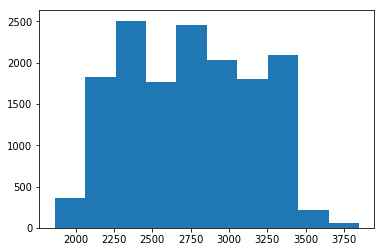

In [83]:
plt.hist(full_features['Elevation'])

In [84]:
N = len(full_features['Aspect'])
print(N)

15120


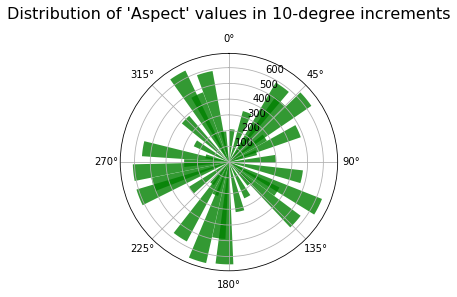

In [85]:
# Adapting code from https://stackoverflow.com/questions/22562364/circular-histogram-for-python

# Start from the center of the disc
bottom = 0

# Break the arc up into 10-degree increments
theta = range(0, 360, 10)

# Bar height is equal to the number of `Aspect` values between X and X + 10
binned_aspects = np.digitize(full_features['Aspect'], theta)
radii = [sum(binned_aspects==x) for x in range(0, len(theta))]

# Divide arc evenly between Xbands for bar width
N = 36  # b/c 10-degree arcs
width = (2 * np.pi) / N

max_height = max(radii) + 10 # Highest
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

ax.set_theta_zero_location('N') # 0 degrees North is up
ax.set_theta_direction(-1) # Go clockwise

# Use custom colors and opacity
for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_facecolor('green')
    bar.set_alpha(0.8)

plt.title('Distribution of \'Aspect\' values in 10-degree increments\n',
         fontsize=16)
plt.show()

One thing of note is that the `Soil_Type7` and `Soil_Type15` are never true, so this feature tells us nothing.  These features should be removed before any modeling is done.

In [ ]:
bins = np.arange(0, 360, 10)
cut = [0, 45, 90, 135, 180, 225, 270, 315, 360]

print(bins)
pd.cut(bins, cut)